# Проектная работа "Проведение исследования для компании мегафон"
## Исполнитель: Голубкина Анна

Проведение исследования для компании "Мегафон" о зависимости оценки клиента в опросе от технических показателей.

#### Проведение опроса
В ходе опроса компания «Мегафон» предложила своим клиентам оценить уровень удовлетворённости качеством связи по десятибалльной шкале (где 10 — это «отлично», а 1 — «ужасно»). 

Если клиент оценивал качество связи на 9 или 10 баллов, опрос заканчивался. Если клиент ставил оценку ниже 9, задавался второй вопрос — о причинах неудовлетворённости качеством связи с предоставленными пронумерованными вариантами ответа. Ответ может быть в свободном формате или перечислить номера ответов через запятую.

## Подключение библиотек и скриптов

In [1]:
# Линейная алгебра, обработка данных, статистика, регулярные выражения
import pandas as pd # linear algebra
import numpy as np  # data processing
import statistics
import re

# Визуализация
from IPython.display import display,Markdown
import seaborn as sns
import matplotlib.pyplot as plt

#Статистический анализ
import scipy.stats as st
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Функции для визуализации и работы с данными 

In [3]:
def q2_bin(data,y):
    """Функция для обработки ответов на вопрос Q2 и запись в нулевую матрицу y"""
    i = 0
    for index, row in tmp.iterrows(): # построчная  итерация 
        i += 1
        for index, item in row.items():   # в соответствующую ячейку матрицы y ставим 1 если данный ответ был
            for value in range(len(item)):
                y[(i-1),(item[value]-1)] = 1
    return y

In [4]:
def q2_answer(item):
    """Функция приведения ответов на вопрос Q2 к необходимому виду"""
    
    #item - строка с ответами на вопрос
    
    q2_list = []

    reg = re.findall('\w+', item)
    reg = list(map(int, reg)) # Пробразуем к целому


    # Двузначное число делим по символам
    for el in reg:
        if 1 <= el <= 7:
            q2_list.append(el)  
        elif el > 10:
            # Если двузначное число, делим по символам и проверяем вхождение в диапазон
            q2_list += [int(x) for x in str(el) if 1 <= int(x) <= 7]
        else:
            pass

    return list(set(q2_list))

In [5]:
def full_row(row):
    """Функция для формирования группы пользователей довольных услугами(1)
    /не довольных услугами(0)"""
    if row['Q1'] == 9:
        val = 1
    elif row['Q1'] == 10:
        val = 1
    else:
        val = 0
    return val

In [6]:
def print_md(string):
    """Функция print Markdown"""
    
    display(Markdown(string))

In [7]:
def my_hist(data, col, title=None, xlab=None, ylab=None, median=False, mean=False, hue=None):
    """Функция отрисовки гистограммы"""

    plt.figure(figsize=(8, 4))
    sns.histplot(data, x=col, kde=False,  discrete=True)
    plt.title(title, fontsize=14, pad=15)
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.xticks(np.arange(data[col].min(), data[col].max()+1))


    plt.axvline(data[col].mean(), color='red',
                    linestyle='dashed', label='среднее', alpha=0.5)
    plt.legend()

    plt.axvline(data[col].median(), color='green',
                    linestyle='dashed', label='медиана', alpha=0.7)
    plt.legend()

    return plt.show()

In [8]:
def plot_all_param(data, log=False):
    """Функция визуализации технических причин влияющих на оценку абонента.
    Исключаются ейтральные оценки и сравниваются две группы с хорошими оценками и плохими"""
    
    # Убрать оценки
    data = data[(data.Q1 >= 7) | (data.Q1 <= 6)]
    
    # Деление на две группы
    data['evaluation'] = data['Q1']\
        .apply(lambda x: 'Не удовлетворены' if x <= 6 else 'Удовлетворены')

    fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharey=False)

    fig.suptitle(f'Плотность распределения', y=1., fontsize=14)

    num = 0

    for i in range(0, 2):
        for j in range(0, 4):
            param = tech_params[num]
            sns.histplot(ax=axes[i][j], data=data[data[param] != 0],
                         x=param, hue='evaluation', stat='density',
                         hue_order=data.evaluation.unique(),
                         kde=True, log_scale=log, legend=False)

            axes[i][j].set_ylabel('Плотность')

            if log == True:
                axes[i][j].set_xlabel('Log: ' + re.findall(r'\((\S+)\)', tech_params[num])[0])
            else:
                axes[i][j].set_xlabel(re.findall(r'\((\S+)\)', tech_params[num])[0])
                
            axes[i][j].set_title(param)
            plt.legend(data.evaluation.unique())
            sns.despine()
            num += 1
    plt.subplots_adjust(wspace=0.25, hspace=.4)
    return plt.show()

In [9]:
def bootstrap(data_a, data_b, N=5000, size=200, title=None):
    """Функция bootstrap, расчет и визуализация"""
    
    # Реализация бутстрэпа
    mean_samples_a = []
    mean_samples_b = []
    buf = []
    
    for i in range(N):
        sample_a =  data_a.sample(size)
        mean_samples_a.append(np.mean(sample_a))
        sample_b =  data_b.sample(size)
        mean_samples_b.append(np.mean(sample_b))
        buf.append(np.mean(sample_a)-np.mean(sample_b))
        
    # Полотно графика
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(title, y=1.05, fontsize=14)
    
    # Графики распределения по группам А и Б
    sns.histplot(mean_samples_a, alpha=.8, ax=ax[0], kde=True, stat='density')
    sns.histplot(mean_samples_b, alpha=.8, ax=ax[0], kde=True, stat='density')
    
    # Интервалы и медиана
    ax[0].axvline(np.percentile(mean_samples_a, 2.5), linestyle='-', color='r', linewidth=3)
    ax[0].axvline(np.percentile(mean_samples_a, 97.5), linestyle='-', color='r', linewidth=3)
    ax[0].axvline(np.median(mean_samples_a), linestyle='--', color='r', linewidth=3)
    ax[0].axvline(np.percentile(mean_samples_b, 2.5), linestyle='-', color='g', linewidth=3)
    ax[0].axvline(np.percentile(mean_samples_b, 97.5), linestyle='-', color='g', linewidth=3)
    ax[0].axvline(np.median(mean_samples_b), linestyle='--', color='g', linewidth=3)
    ax[0].set_title('Плотность распределения по группам \n с хорошими и плохими оценками', fontsize=14)
    ax[0].set_ylabel('Плотность')
    ax[0].set_xlabel(re.findall(r'\((\S+)\)', title)[0])
    ax[0].legend(['Хорошие','Плохие'])
    
    # График распределения разности по группам А и Б
    sns.histplot(buf, alpha=.8, ax=ax[1], kde=True, stat='density', color='g')
   
    # Интервалы и медиана
    ax[1].axvline(np.percentile(buf, 2.5), linestyle='-', color='b', linewidth=3)
    ax[1].axvline(np.percentile(buf, 97.5), linestyle='-', color='b', linewidth=3)
    ax[1].axvline(np.median(buf), linestyle='--', color='b', linewidth=3)
    ax[1].set_title('Плотность разницы средних', fontsize=14)
    ax[1].set_ylabel('Плотность')
    ax[1].set_xlabel(re.findall(r'\((\S+)\)', title)[0])
    
    return plt.show()

# Codebook
megafon.csv содержит следующие значения: 

     user_id — идентификатор абонента;
     Q1 — ответ на первый вопрос;
     Q2 — ответ на второй вопрос;
     Total Traffic(MB) — объем трафика передачи данных 1 ; 
     Downlink Throughput(Kbps) — средняя скорость «к абоненту» 2 ;
     Uplink Throughput(Kbps)— средняя скорость «от абонента» 3 ;
     Downlink TCP Retransmission Rate(%) — частота переотправок пакетов «к абоненту» 4 ;
     Video Streaming Download Throughput(Kbps) — скорость загрузки потокового видео 5 ;
     Video Streaming xKB Start Delay(ms) — задержка старта воспроизведения видео 6 ;
     Web Page Download Throughput(Kbps) — скорость загрузки web-страниц через браузер 7 ;
     Web Average TCP RTT(ms) — пинг при просмотре web-страниц8 .
<ol>
    <li><b> Насколько активно абонент использует мобильный интернет.</b></li>
<li><b>Считается по всему трафику передачи данных.</b></li>
<li><b>Считается по всему трафику передачи данных.</b></li>
<li><b>Чем выше, тем хуже. Если в канале возникает ошибка, пакет переотправляется. Снижается полезная скорость.</b></li>
<li><b>Чем выше, тем лучше — меньше прерываний и лучше качество картинки.</b></li>
<li><b>Сколько времени пройдёт между нажатием на кнопку Play и началом воспроизведения видео. Чем меньше это время, тем быстрее начинается воспроизведение.</b></li>
<li><b>Чем выше, тем лучше.</b></li>
<li><b>Чем меньше, тем лучше — быстрее загружаются web-страницы.</b></li>
</ol>
Первый технический показатель представлен как сумма за период в одну неделю перед участием в опросе. Остальные технические показатели отображают среднее значение по данному признаку за период в одну неделю перед участием в опросе.

## Загрузка данных

In [10]:
data = pd.read_csv('/Users/anna_g/Desktop/skillbox/megafon.csv',header=0)
data.head(3)

,user_id,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
0,1,5,NaN,775.48846,360.13,86.56,3.93,1859.15,2309,1007.82,83
1,2,5,4,861.96324,3023.54,411.18,1.27,667.47,2080,255.36,425
2,3,1,4,261.11860,790.96,34.20,1.79,1079.60,6367,535.85,485


In [11]:
data.shape

(3112, 11)

Для частей статистического анализа необходимо копировать набор даныхх

In [12]:
data_group = data.copy()

## 2. Предобработка данных

In [13]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3112 entries, 0 to 3111
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   user_id                                    3112 non-null   int64  
 1   Q1                                         3110 non-null   object 
 2   Q2                                         1315 non-null   object 
 3   Total Traffic(MB)                          3112 non-null   float64
 4   Downlink Throughput(Kbps)                  3112 non-null   float64
 5   Uplink Throughput(Kbps)                    3112 non-null   float64
 6   Downlink TCP Retransmission Rate(%)        3112 non-null   float64
 7   Video Streaming Download Throughput(Kbps)  3112 non-null   float64
 8   Video Streaming xKB Start Delay(ms)        3112 non-null   int64  
 9   Web Page Download Throughput(Kbps)         3112 non-null   float64
 10  Web Average TCP RTT(ms) 

##### Оценим количество нулевых значений по вопросу Q1

In [14]:
data[data['Q1'].isnull()] 

,user_id,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
371,372,NaN,NaN,286.62191,2320.25,75.60,3.84,4499.92,1790,1035.64,200
3026,3027,NaN,NaN,875.62280,7258.66,226.08,0.60,8336.42,1087,3112.83,54


In [15]:
(data[data['Q1'] == '0']).count()

user_id                                      10
Q1                                           10
Q2                                            0
Total Traffic(MB)                            10
Downlink Throughput(Kbps)                    10
Uplink Throughput(Kbps)                      10
Downlink TCP Retransmission Rate(%)          10
Video Streaming Download Throughput(Kbps)    10
Video Streaming xKB Start Delay(ms)          10
Web Page Download Throughput(Kbps)           10
Web Average TCP RTT(ms)                      10
dtype: int64

##### Оценим количество нулевых значений по вопросу Q2

In [16]:
tmp = data[data['Q2'].isnull()]
tmp

,user_id,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
0,1,5,NaN,775.48846,360.13,86.56,3.93,1859.15,2309,1007.82,83
5,6,3,NaN,416.67461,1346.89,175.53,1.08,4553.01,2136,1587.58,551
7,8,9,NaN,550.44581,3428.69,164.44,1.05,16753.96,1061,3037.36,88
11,12,1,NaN,730.53759,4020.94,569.49,1.57,8747.53,1556,1347.73,77
12,13,1,NaN,828.47641,2171.11,46.16,8.49,2483.79,2504,1923.60,112
...,...,...,...,...,...,...,...,...,...,...,...
3103,3104,10,NaN,253.50271,833.50,242.93,1.82,1135.57,4617,1293.78,114
3105,3106,10,NaN,424.34855,2258.16,150.21,1.56,5623.82,1313,3480.14,109
3106,3107,1,NaN,490.50187,1992.68,85.73,0.87,3477.94,2004,2369.41,245
3109,3110,10,NaN,187.44936,590.29,186.36,2.06,3182.83,2195,1094.62,109


Для полученных значений проведем анализ, сколько значений NaN соотвествуют оценке 9-10
при ответе на вопрос Q1 

In [17]:
(tmp[tmp['Q1'] == '10']).count()

user_id                                      846
Q1                                           846
Q2                                             0
Total Traffic(MB)                            846
Downlink Throughput(Kbps)                    846
Uplink Throughput(Kbps)                      846
Downlink TCP Retransmission Rate(%)          846
Video Streaming Download Throughput(Kbps)    846
Video Streaming xKB Start Delay(ms)          846
Web Page Download Throughput(Kbps)           846
Web Average TCP RTT(ms)                      846
dtype: int64

In [18]:
(tmp[tmp['Q1'] == '9']).count()

user_id                                      238
Q1                                           238
Q2                                             0
Total Traffic(MB)                            238
Downlink Throughput(Kbps)                    238
Uplink Throughput(Kbps)                      238
Downlink TCP Retransmission Rate(%)          238
Video Streaming Download Throughput(Kbps)    238
Video Streaming xKB Start Delay(ms)          238
Web Page Download Throughput(Kbps)           238
Web Average TCP RTT(ms)                      238
dtype: int64

Доля пропусков  и некорректных ответов ("0") среди ответов пользователей на вопрос Q1 в наборе данных мала. Ввиду того, что невозможно идентифицировать пользователей или понять причину пропуска удалим данные строки из набора данных.


Пропуски пользователей на ответ Q2 объясняются тем, что пользователи ответили только на первый вопрос Q1, без дальнейшего уточнения. Большая часть таких пропусков (60,3%) имеют ответ на вопрос Q1 в диапазоне от 9 до 10 баллов. В соответсвии с инфографикой в постановке задачи тестирование заканчивается и ответ на вопрос Q2 не требуется.

### Однако 713 пропусков, при оценке в диапазоне от 1 до 8 требуют более тщательного рассмотрения.
Принимание во внимание, что данные характеризующие показатели качества связи не имеют пропусков, необходимо проверить корректность ответов пользователей. 

In [19]:
data.describe(include=object)

,Q1,Q2
count,3110,1315
unique,49,51
top,10,3
freq,846,190


Большое количество уникальных значений при ответе на первый вопрос, при ограниченном диапазоне ответов говорит о выбросах и некорректных ответах на воставленный в исследовании вопрос.

In [20]:
print(data['Q1'].unique())

['5' '1' '8' '2' '3' '9' '10' '7' '4' '11' '6' '2, 9' '0' '1, 3' '19' '15'
 nan '1, 6' '***** ** ***'
 '3 - дер.Ширяево Волоколамского района, 9 - в Москве' '10, 9'
 'Чем даль ше,тем лучше.Спасибо за ваш труд.Оценка 10 !'
 'ОЦЕНКА-3/НЕВАЖНО/' 'Отвратительно' 'Я ценой услуг не удовлетворен'
 'Пока не понял' '3, 9' '5, 6' '0, 1, 5' '5, 7' 'Hi'
 '4. Тульская область Заокский район. Романовские дачи связи почти нет'
 'Немагу дать атценку денги незашто снимаеть скоро выклучаю' '10, 50'
 'Очень  хорошо. Обслуживания  я довольно. Спасибо вам.555' '?' 'Поохое'
 'Когда в Москве-10 а когда в калужской области в деревне Бели-1' 'Нет'
 'Да' 'Ужасно'
 '3 тройка, связь отвратительная, жалко платить за такой тарив'
 'Чдтчдтччдтччч' '3, 7' '20, 89031081392' '1, 8' 'Без з' '10, 5' '2, 5'
 'Я в Смол. Области живу сейчас, не пользуюсь телефоном совсем']


In [21]:
print(data['Q1'].nunique())

49


Уникальные значения на вопрос Q1 сложно интерпретировать, так как встречаются ответ "Да", "Нет" "Пока не понял" "Я ценой услуг не удовлетворен".Некоторым ответам однозначно сложно присвоить какой-либо балл, характеризующий удовлетворенность/неудовлетворенность качеством связи.
Для дальнейшей работы с полученными уникальными значениями, необходимо понять процент ошибки в наборе данных.

### 2.1 Обработка ответов на вопрос Q1

In [22]:
# Допустимые варианты ответов для вопроса Q1
q1_answer = [str(x) for x in range(1, 11)]

In [23]:
# Подсчет количества ошибочных ответов на вопрос Q1
q1_error = data[~data['Q1'].isin(q1_answer)]['Q1'].count() 
print(f'Количество ошибочных ответов на вопрос Q1 - {q1_error}')

Количество ошибочных ответов на вопрос Q1 - 52


#### Полученное количество ошибочных ответов менее 2% от всего набора данных, в силу незначительного колличества можно их удалить из данных.

In [24]:
# Удалим пропуски ответов на вопрос Q1
data = data[~data.Q1.isna()]

In [25]:
data.head(2)

,user_id,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
0,1,5,NaN,775.48846,360.13,86.56,3.93,1859.15,2309,1007.82,83
1,2,5,4,861.96324,3023.54,411.18,1.27,667.47,2080,255.36,425


In [26]:
# Удалим строки с значением  '0' в ответе  вопросе Q1
data = data.drop(data[data.Q1 == 0].index)
data = data.drop(data[data.Q1 == '0'].index)

In [27]:
data = data[data['Q1'].isin(q1_answer)]
data.Q1 = data.Q1.astype('int64')

### 2.2 Обработка ответов на вопрос Q2

In [28]:
print(data['Q2'].unique())

[nan '4' '3' '2, 3, 4' '4, 5' '1, 3, 4' '1, 3, 4, 5' '1, 3' '3, 4' '1, 2'
 '3, 5' '1' '7' '1, 4' '1, 2, 3, 4, 5' '2, 3' '1, 2, 3, 4' '2, 3, 4, 5'
 '3, 4, 5' '1, 2, 5' '1, 5' '1, 2, 4' '6' '1, 4, 5' '1, 2, 3' '2, 5'
 '2, 4, 5' '1, 2, 7' '5' '2' '1, 2, 3, 4, 5, 6' '0, 1, 7' '4, 7' '1, 4, 7'
 '0, 3' '1, 3, 4, 5, 7' '3, 7' '1, 3, 4, 7' '3, 4, 5, 7' '2, 4' '5, 6'
 '1, 2, 3, 5' '1, 3, 5' '1, 2, 34' '1, 2, 4, 5' '0, 05, 2, 27, 7'
 '1, 3, 7' '3, 4, 7' '1, 2, 3, 4, 7' '10' '0' '1, 2, 3, 7']


In [29]:
print(data['Q2'].nunique())

51


Полученные значения за небольшим исключением пропусков и двузначных чисел заполнены корректно. Скорее всего в двухзначных числах пропущены запятые при перечислении ответов.

In [30]:
data.fillna('0', inplace=True)

In [31]:
# заполнение пропущенных ответов на вопрос Q2 средним значением 
data.loc[data['Q2'] == '0', 'Q2'] = '1'
data.head(2)

,user_id,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
0,1,5,1,775.48846,360.13,86.56,3.93,1859.15,2309,1007.82,83
1,2,5,4,861.96324,3023.54,411.18,1.27,667.47,2080,255.36,425


##### Оценим средние значения ответов на вопросы Q1 и Q2

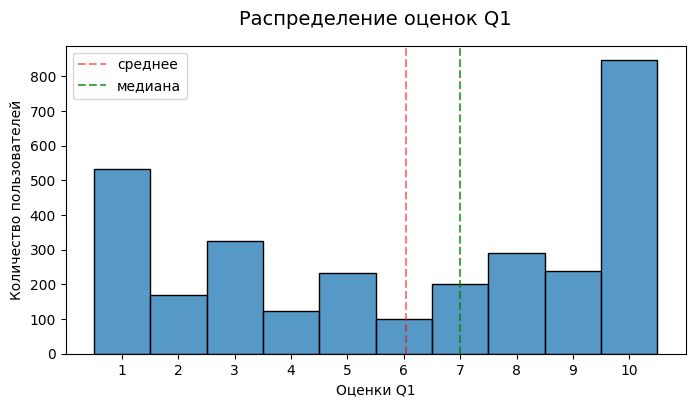

In [32]:
my_hist(data=data, col='Q1', title='Распределение оценок Q1',
            xlab='Оценки Q1', ylab='Количество пользователей', median=True, mean=True, hue='evaluation')

График распределения ответов на вопрос Q1 позволяет увидеть, что большинство ответивших абонентов поставило оценку 10 баллов, в тоже время мы видим большое число абонентов поставивших оценку "очень плохо" - 1 балл. Можно предположить, что клиенты чаще ставят крайние варианты ответов (или совсем доволен или совсем не доволен).

Стоит проанализировать группу абонентов, поставивших оценки 1 и 2, на  закономерность.

Среднее и медианное значение 6 и 7 соответственно, что говорит о небольшом смещении распределения и достаточно хорошем среднем уровнем оценки качества. 

Мы получили метрики, которые необходимо улучшать: 

Средняя оценка - 6 баллов
Медианная оценка - 7 баллов

## 3. Разведочный анализ

#### Рассмотрим количество причин выбранных абонентами в качестве ответа на вопрос Q2

In [33]:
data_q2_mean = data.copy()
data_q2_mean['Q2'] = data_q2_mean['Q2'].apply(lambda x: q2_answer(x))

# Количество претензионных оценок на клиента
data_q2_mean['count_answer'] = data_q2_mean['Q2'].apply(lambda x: len(x))

In [34]:
# Градация оценок
grad_mark  = {1: 'ужасно',
              2: 'ужасно',
              3: 'плохо',
              4: 'плохо',
              5: 'нейтрально',
              6: 'нейтрально',
              7: 'хорошо',
              8: 'хорошо',
              9: 'отлично',
              10: 'отлично'}

data_q2_mean['grad_mark'] = data_q2_mean['Q1'].map(grad_mark)

In [35]:
index = data_q2_mean['Q1'].sum() / (data_q2_mean['Q1'].count() * 10)
mean_csat = data_q2_mean['Q1'].sum() / data_q2_mean['Q1'].count()

print_md(f'Процент пользователей, удовлетворенных услугами - {index:.0%}')
print_md(f'Средняя оценка, удовлетворенности услугами - {mean_csat:.2}')

Процент пользователей, удовлетворенных услугами - 60%

Средняя оценка, удовлетворенности услугами - 6.0

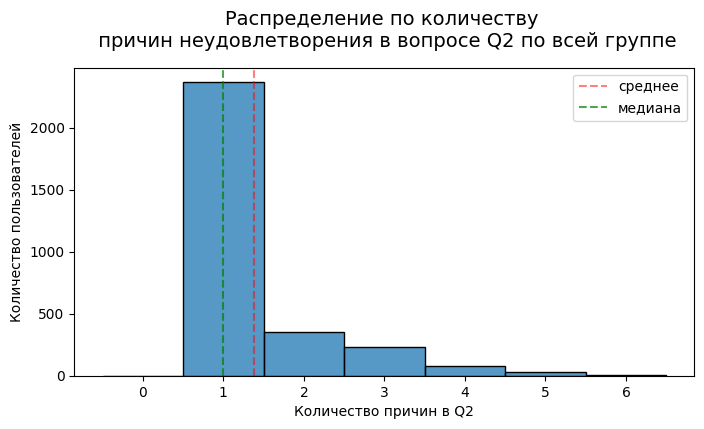

In [36]:
my_hist(data=data_q2_mean, col='count_answer', 
            title='Распределение по количеству \n причин неудовлетворения в вопросе Q2 по всей группе',
            xlab='Количество причин в Q2', ylab='Количество пользователей', median=False, mean=True)

На графике замено большое количество некорректно отправленных абонентами ответов на вопрос Q2.
Необходимо отметить, что среди не ответивших абонентов на второй вопрос есть часть, которые поставили оценку в 9-10 баллов на вопрос Q1 не участвовали далее в опросе. 
Отсеим эту группу и посмотрим только на тех клиентов, кто оценил качество связи на 8 и менее баллов.

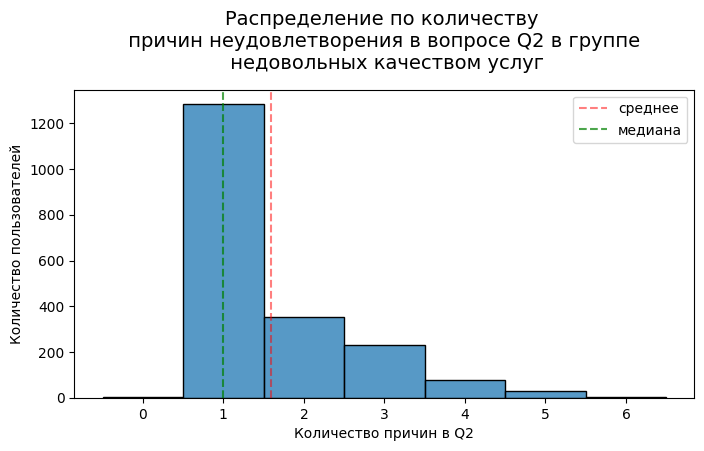

In [37]:
my_hist(data=data_q2_mean[~(data_q2_mean['Q1'] >= 9)], col='count_answer',
            title='Распределение по количеству \n причин неудовлетворения в вопросе Q2 в группе \n недовольных качеством услуг',
            xlab='Количество причин в Q2', ylab='Количество пользователей', median=False, mean=True)

Более 600 абонентов не сформулировали ответ на второй вопрос о причинах своей неудовлетворённости качеством связи. 
Ответ можно было дать в свободном формате или перечислить номера ответов через запятую.
Можно сделать допущение, что у клиентов не давших ответ, затруднились с ответом. Присвоим этой группе номер ответа на Q2 - 6. 

In [38]:
# Присвоим нулевое значение на Q2, клиентам довольных услугами
data_q2_mean.loc[data_q2_mean['Q1'] >= 9, 'Q2'] = 0

In [39]:
# Присвоим значение 6 на Q2, клиентам не довольных услугами и не давших ответ на вопрос Q2
data_q2_mean.loc[(data_q2_mean['count_answer'] == 0) & (data_q2_mean['Q1'] <= 8), 'Q2'] = 6
# Изменим количество оценок на Q2 с нуля на 1, клиентам не довольных услугами и не давших ответ на вопрос Q2
data_q2_mean.loc[data_q2_mean['Q2'] == 6, 'count_answer'] = 1

In [40]:
# Развернем ответы Q2
df_long = data_q2_mean.explode('Q2').reset_index(drop=True)
df_long.Q2 = df_long.Q2.astype('int64')

In [41]:
# Разметка набора данных по предложенным вариантам ответа
legend = {0: 'Устраивает качество связи',
          1: 'Недозвоны, обрывы при звонках',
          2: 'Время ожидания гудков при звонке',
          3: 'Плохое качество связи в зданиях',
          4: 'Медленный мобильный интернет',
          5: 'Медленная загрузка видео',
          6: 'Затрудняюсь ответить',
          7: 'Свой вариант'}

df_long['legend'] = df_long['Q2'].map(legend)

In [42]:
# Расчет среднего балла
df_q2_mean = df_long.groupby(['Q2', 'legend']).agg({'Q1' : 'mean'})
df_q2_mean.rename(columns={'Q1' : 'Средний балл'}, inplace=True)

display(df_q2_mean.round(2).style\
        .background_gradient(cmap='viridis', low=.5, high=0)\
        .set_caption('Средний балл по ответам на Q2')\
        .format("{:}"))

,,Средний балл
Q2,legend,
0,Устраивает качество связи,9.78
1,"Недозвоны, обрывы при звонках",3.77
2,Время ожидания гудков при звонке,3.6
3,Плохое качество связи в зданиях,3.89
4,Медленный мобильный интернет,3.75
5,Медленная загрузка видео,3.75
6,Затрудняюсь ответить,5.71
7,Свой вариант,2.92


Средний балл по каждому варианту Q2 примерно одинаковый 3.6 - 3.9. 

Выделяется вариант ответа "Свой вариант", вероятно в этой категории ответов есть развернутые ответы на недоувлетворенность услугами связи.

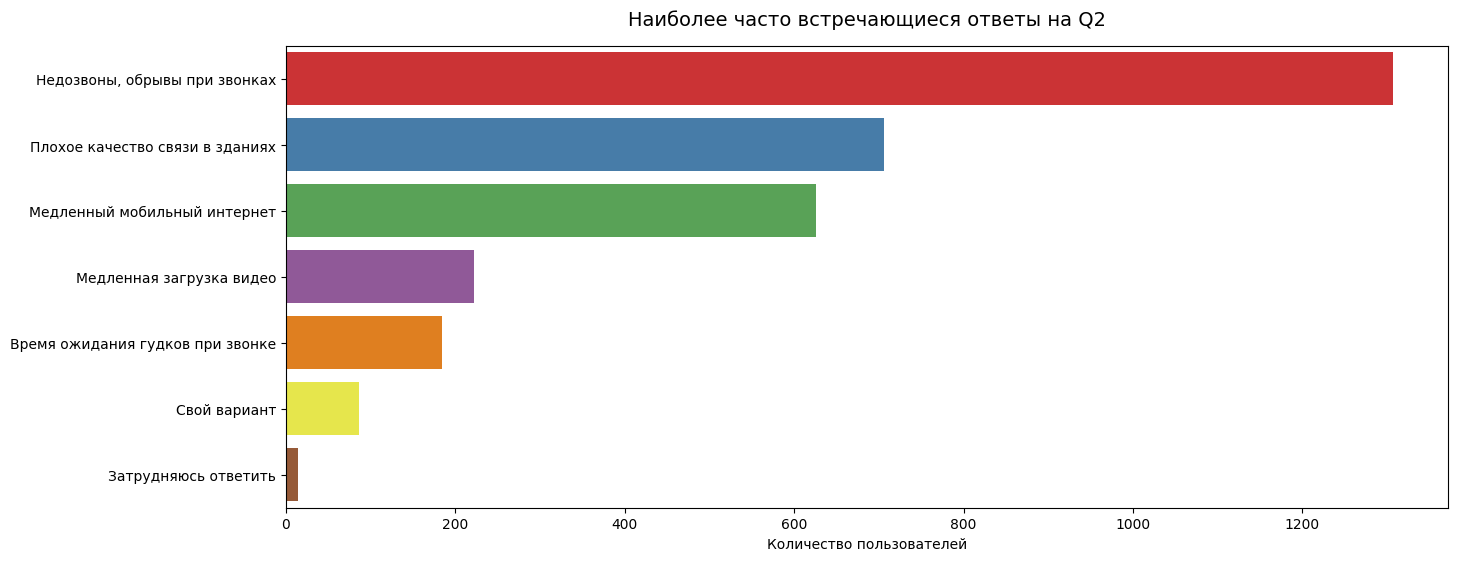

In [43]:
df_bad = df_long[~df_long.Q2.isin([0])]

plt.figure(figsize=(15, 6))
sns.countplot(y='legend', data=df_bad,
              order=df_bad.groupby(['legend']).count().sort_values(by='user_id', ascending=False).index, 
              orient='h',palette = "Set1")
plt.title('Наиболее часто встречающиеся ответы на Q2', fontsize=14, pad=15)
plt.xlabel('Количество пользователей')
plt.ylabel('')
plt.show()

Наибольшее внимание абоненты обращают на качество:
<ul>
<li>Недозвоны, обрывы при звонках,</li>
<li>Качество связи в зданиях,</li>
<li>Медленный мобильный интернет.</li>
</ul>
Эти три категории являются наиболее приоритетными ввиду большого количества клиентов, упомянувших о них. 
Вариант "затрудняюсь ответить" не рассматривается, так как невозможно идентифицировать причину недовольства. 
Эту группу людей предлагается включить в участие в аналогичном опросе по другим критериям сервиса.

In [44]:
# подсчет ответов абонента на вопрос Q2
data['count_answer'] = data['Q2'].apply(lambda x: len(x))

In [45]:
# Присвоим значение 6 на Q2, клиентам не довольных услугами и не давших ответ на вопрос Q2
data.loc[(data['count_answer'] == 0) & (data['Q1'] <= 8), 'Q2'] = 6
# Изменим количество оценок на Q2 с нуля на 1, клиентам не довольных услугами и не давших ответ на вопрос Q2
data.loc[data['Q2'] == 6, 'count_answer'] = 1

In [46]:
# Приведение ответов на вопрос Q2 в тип list, для дальнейшей работы с ними
data['Q2'] = data['Q2'].apply(lambda x: q2_answer(x))

In [47]:
data.head(2)

,user_id,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms),count_answer
0,1,5,[1],775.48846,360.13,86.56,3.93,1859.15,2309,1007.82,83,1
1,2,5,[4],861.96324,3023.54,411.18,1.27,667.47,2080,255.36,425,1


#### Создадим новые переменные из списка ответов на вопрос Q2

In [48]:
x = np.zeros((3068,7))
x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [49]:
# копируем столбец с ответами на вопрос Q2
tmp = data[['Q2']].copy()
tmp.shape

(3058, 1)

In [50]:
# Используем функцию построчного считыватывания ответов на вопрос Q2
# заполняем соответсвующие ячейки матрицами 1, если был выбран данный вопрос
q2_bin(tmp,x)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [51]:
tmp = pd.DataFrame(q2_bin(tmp,x)) 

In [52]:
tmp = tmp.rename(columns={0: "Q2_1", 1: "Q2_2",
                              2: "Q2_3",3: "Q2_4", 4: "Q2_5",
                              5: "Q2_6", 6:"Q2_7"})
tmp.insert(1, 'New_ID',range(1, 1 + len(tmp)))

In [53]:
df = pd.merge(data, tmp, left_on = 'user_id', right_on = 'New_ID')

In [54]:
df = df.drop('New_ID', axis=1)

In [55]:
df.head(2)

,user_id,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms),count_answer,Q2_1,Q2_2,Q2_3,Q2_4,Q2_5,Q2_6,Q2_7
0,1,5,[1],775.48846,360.13,86.56,3.93,1859.15,2309,1007.82,83,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,5,[4],861.96324,3023.54,411.18,1.27,667.47,2080,255.36,425,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#### Создадим новую переменную принадлежности к группе довольных/недовольных качеством услуг

In [56]:
df['Group'] = df.apply(full_row,axis=1)

# 4. Исследования

## 4.1 Зависимость оценки от технических параметров связи

## Постановка задачи

Анализ технических параметров и их влияния на оценку абонента. 
Так как основное внимание абоненты уделяют технической строне качества связи, рабюоты мобильного инетрнета. 
Данные анализ поможет направить усилия компании на улучшение именно необходимых характеристик, что позволит повысить как удовлетворённость своих клиентов качеством услуг,  так для их удержания.

## Разведочный анализ

Рассмотрим медианные значения параметров взависимости от характеристики оценки.

In [57]:
# Медианные значения
df_grouped = data_q2_mean.groupby('grad_mark').agg({'Total Traffic(MB)' : 'median', 
                                     'Downlink Throughput(Kbps)' : 'median',
                                     'Uplink Throughput(Kbps)' : 'median',
                                     'Downlink TCP Retransmission Rate(%)' : 'median',
                                     'Video Streaming Download Throughput(Kbps)' : 'median',
                                     'Video Streaming xKB Start Delay(ms)' : 'median',
                                     'Web Average TCP RTT(ms)' : 'median',
                                     'Web Page Download Throughput(Kbps)' : 'median'}).round(2).reset_index()
# Cортировка характеристик
df_grouped['order'] = df_grouped['grad_mark'].map({'ужасно' : 0,
                                                    'плохо' : 1,
                                                    'нейтрально' : 2,
                                                    'хорошо' : 3,
                                                    'отлично' : 4,})

df_grouped.sort_values(by='order', inplace=True)
df_grouped.drop(columns=['order'], inplace=True)
df_grouped = df_grouped.rename(columns={'grad_mark' : 'Характеристика'}).reset_index(drop=True)

In [58]:
# Отображение таблицы
display(df_grouped.set_index('Характеристика').style\
        .background_gradient( cmap='GnBu',low=.5, high=0)\
        .set_caption('Медианные значения параметров')\
        .format("{:}"))

,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Average TCP RTT(ms),Web Page Download Throughput(Kbps)
Характеристика,,,,,,,,
ужасно,356.46,1138.66,107.18,1.51,3715.14,1791.0,137.5,1509.0
плохо,379.82,1213.67,119.78,1.41,3721.0,1801.0,135.5,1532.24
нейтрально,421.06,1380.5,127.73,1.25,4570.31,1722.0,119.0,1604.98
хорошо,355.96,1452.07,120.89,1.3,4838.02,1622.0,113.0,1769.81
отлично,353.94,1641.36,124.15,1.19,4934.91,1552.0,105.0,1848.65


In [59]:
tech_params = df_long.columns[3:11].to_list()
# Корреляция
corr = df_long[['Q1'] + tech_params].corr(method='pearson')\
    .sort_values(by=['Q1'], ascending=False).round(2)

In [60]:
# Развернем набор данных по  техническим характеристикам
df_param = data_q2_mean.melt(id_vars=['Q1', 'grad_mark'], value_vars=tech_params, var_name='Параметр', value_name='Значение')\
  .sort_values(by='Q1', ascending=True)\
  .rename(columns={'grad_mark' : 'Характеристика'})

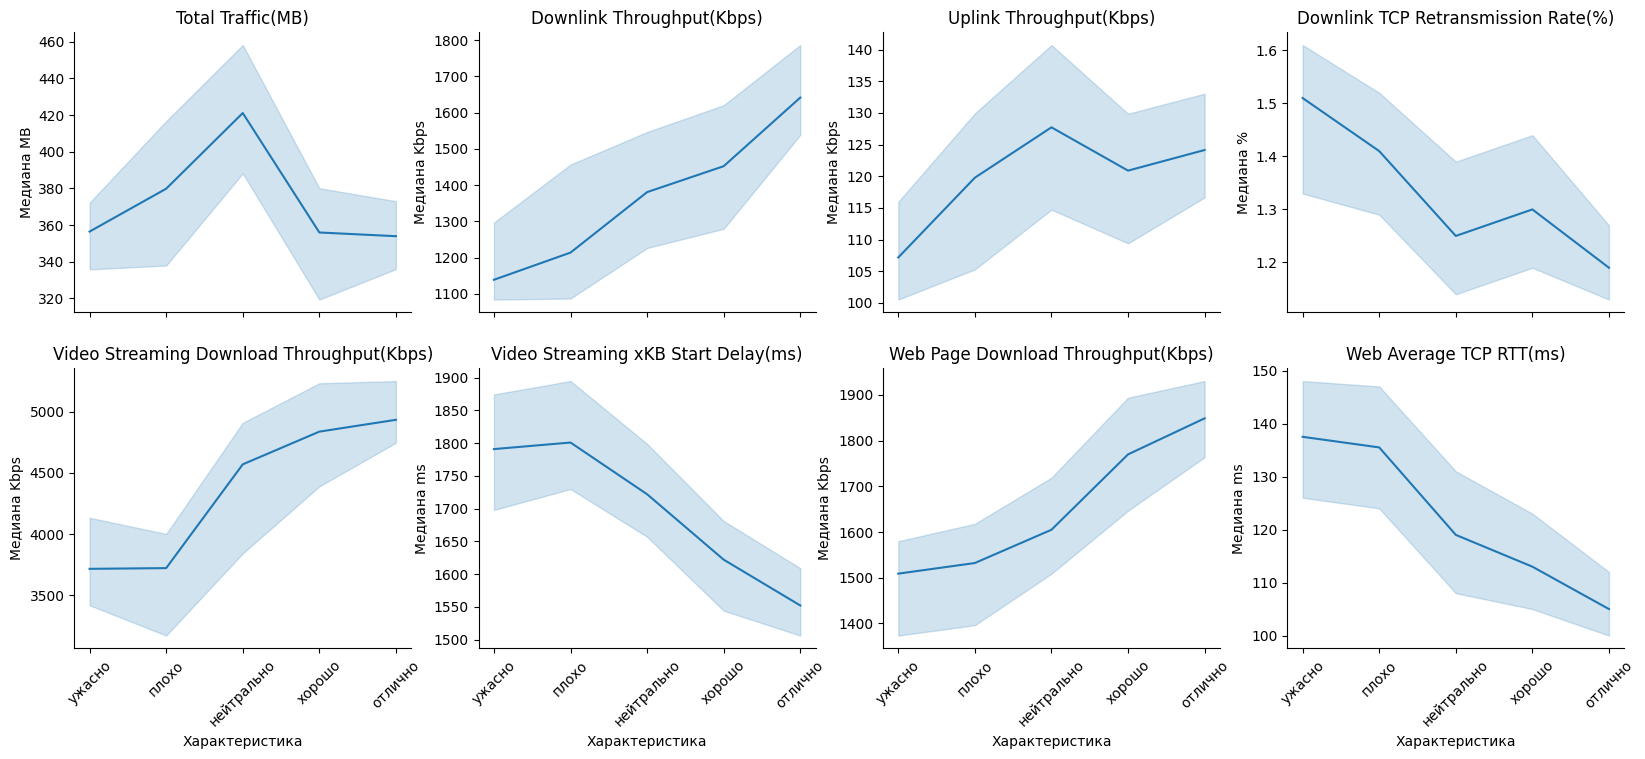

In [61]:
# Визуализация медианных значений по характеристикам
fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex=True)
num = 0
for i in range(0, 2):
    for j in range(0, 4):
        sns.lineplot(y='Значение', x='Характеристика',
                     data=df_param[df_param['Параметр'] == tech_params[num]],
                     err_style="band", estimator=np.median, ax=axes[i][j])

        axes[i][j].set_title(tech_params[num])
        axes[i][j].tick_params(axis='x', rotation=45)
        axes[i][j].set_ylabel('Медиана ' + re.findall(r'\((\S+)\)', tech_params[num])[0])
        sns.despine()
        num += 1
plt.show()

#### Оценка медианных значений по характеристикам
<ul>
<li>Total Traffic(MB) — объем трафика передачи данных, из графика видно, что поставившие средние оценки, более активно используют мобильный интернет.</li>

<li>TDownlink Throughput(Kbps) — средняя скорость «к абоненту». Медианное значение растет и вместе с ней улучшается оценка.</li>

<li>TUplink Throughput(Kbps)— средняя скорость «от абонента». Увеличение оценки с увеличением скорости отдачи.</li>

<li>TDownlink TCP Retransmission Rate(%) — частота переотправок пакетов «к абоненту». У абонентов с более высокими оценками, меньше ошибок со связью.</li>

<li>TVideo Streaming Download Throughput(Kbps) — скорость загрузки потокового видео. С ростом скорости загрузки, растет и оценка качества услуг.</li>

<li>TVideo Streaming xKB Start Delay(ms) — задержка старта воспроизведения видео. Чем меньше по времени загрузка видео, тем более вероятен высокий балл в оценке.</li>

<li>TWeb Page Download Throughput(Kbps) — скорость загрузки web-страниц через браузер. С ростом скорости загрузки, растет и оценка оказываемых услуг.</li>

<li>TWeb Average TCP RTT(ms) — пинг при просмотре web-страниц. Чем меньше, тем лучше — быстрее загружаются web-страницы и тем более высокие оценки ставят абоненты.</li>
</ul>

### Будем проводить анализ по двум группам ответивших абонентов 1 группа - довольных качеством услуг и 2 группа - недовольных/имеющих замечения

#### Рассмотрим плотность распределения по двум группам: 
<ul>
<li>Группа довольных сервисом. Оценка на Q1 больше 7.</li>
<li>Группа недовольных сервисом. Оценка на Q1 меньше 6.</li>
</ul>
Ранее мы  выявили 3 основные причины снижения оценок: 

<ul>
<li>Недозвоны, обрывы при звонках,</li>
<li>Качество связи в зданиях,</li>
<li>Медленный мобильный интернет.</li>
</ul>

### Построим графики плотности распределения технических характеристик связи

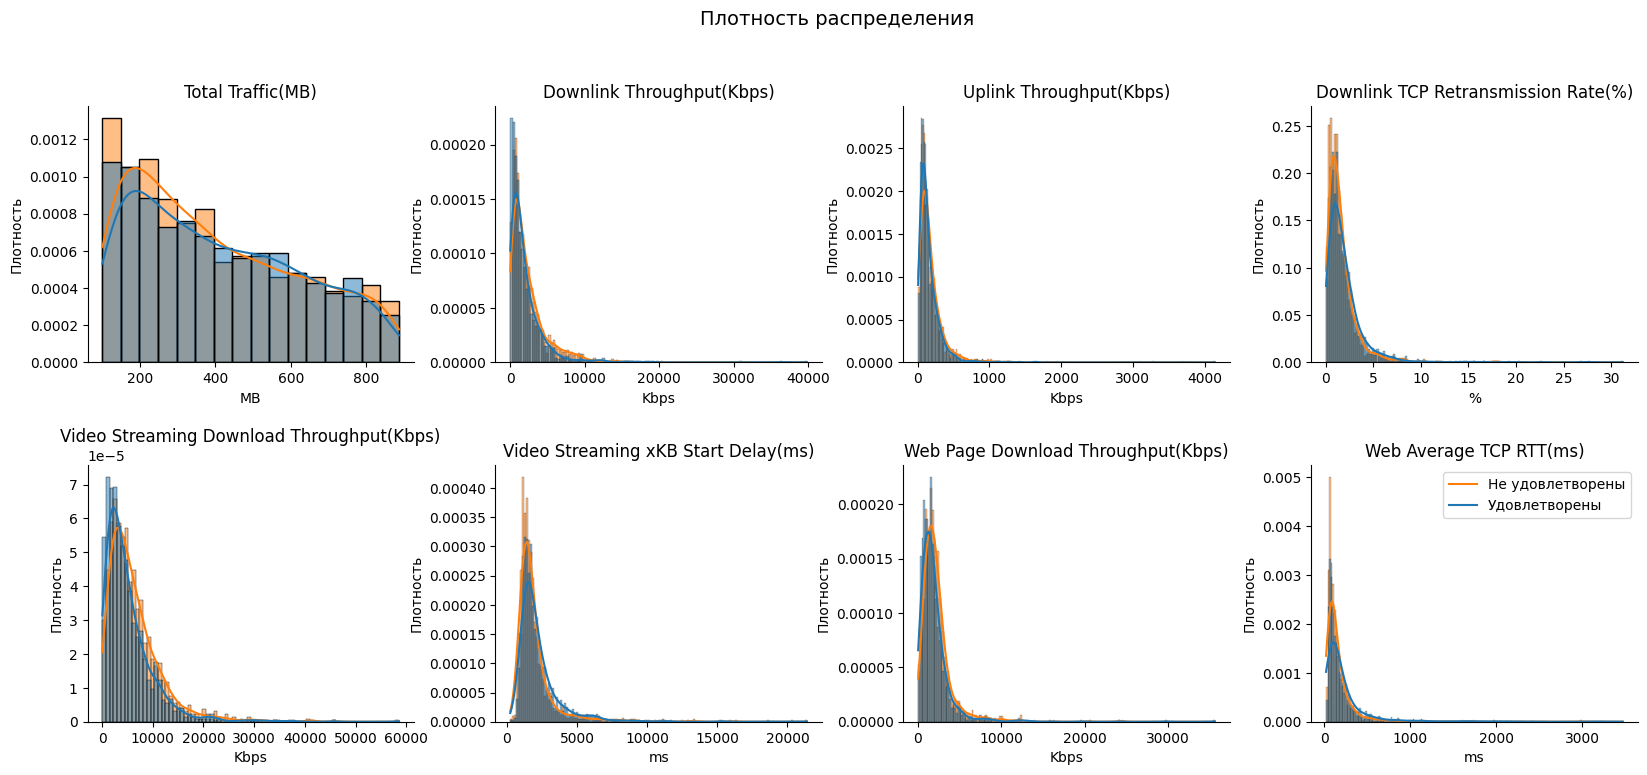

In [62]:
plot_all_param(data=df, log=False)

Плотность распределения у двух групп несколько различается. Оценим эти же данные на логарифмированной шкале.

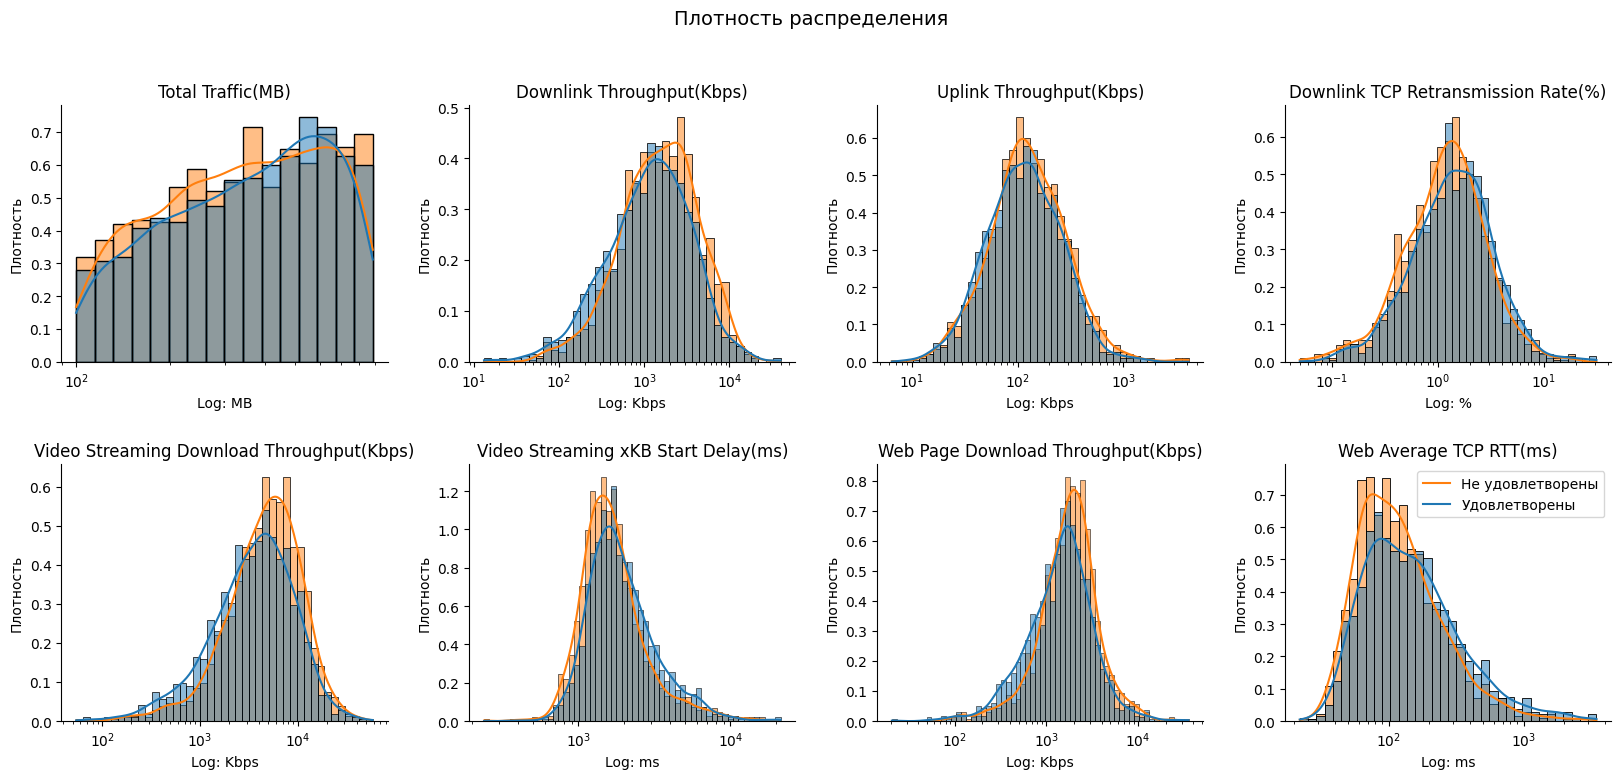

In [63]:
# Логарифмическая шкала
plot_all_param(data=df, log=True)

## Статистический анализ

Значительное влияние на снижение оценки оказывают проблемы с использованием интернета. 

Сравнивать будем две группы, по характеристикам интернет-соединения(она показали высоку корреляцию). Первая группа - абоненты поставившие негативные оценки и вторая - высокие оценки качеству связи. 

В качестве нулевых гипотез примем статистическое равенство средних у различных групп.

**Выделим две группы, которые будем сравнивать:**
<ul>
<li>Группа довольных услугами связи. Оценка на Q1 больше 7.</li>
<li>Группа недовольных услугами связи. Оценка на Q1 меньше 6.</li>
</ul> 

**Гипотезы:**

<ul>
<li>Cкорость загрузки потокового видео (Video Streaming Download Throughput(Kbps)) в двух группах не отличается;</li>
<li>Cредняя скорость «к абоненту» (Downlink Throughput(Kbps)) в двух группах не отличается;</li>
</ul>    
Во всех случаях будем применять бутстрэп средних, из-за несбалансированности выборок и не достаточного количества наблюдений.


### Cкорость загрузки потокового видео (Video Streaming Download Throughput(Kbps)) в двух группах не отличается

Принимается статистическая гипотеза об отсутствии статистической разницы в двух группах по характеристике Video Streaming Download Throughput

$$
  H_0 : \mu_c = \mu_0 \\
  H_1 : \mu_c \neq \mu_0
$$ 

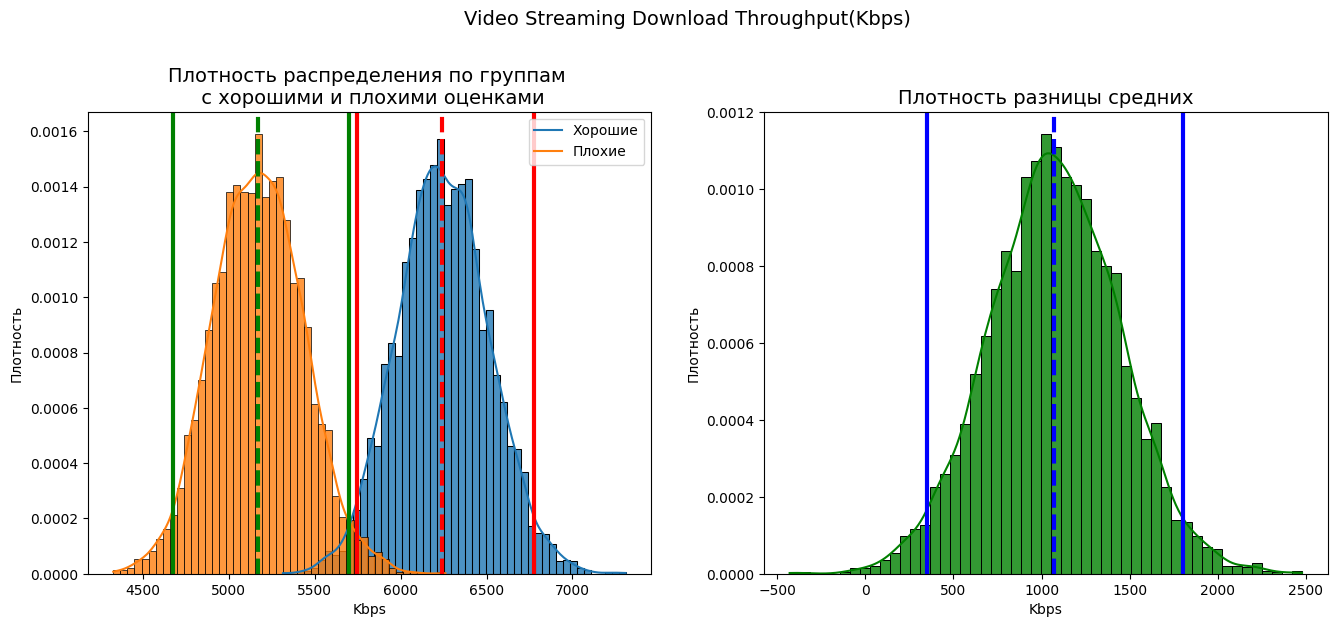

In [64]:
bootstrap(data_a=df[df['Q1'] >= 7]['Video Streaming Download Throughput(Kbps)'],
          data_b=df[df['Q1'] <= 6]['Video Streaming Download Throughput(Kbps)'],
          N=5000, size=300, title='Video Streaming Download Throughput(Kbps)')

Доверительные интервалы не пересекаются. Нулевая гипотеза отвергнута
$$
  H_1 : \mu_c \neq \mu_0
$$ 

### Cредняя скорость «к абоненту» (Downlink Throughput(Kbps)) в двух группах одинакова
Принимается статистическая гипотеза об отсутствии статистической разницы в двух группах по характеристике Downlink Throughput

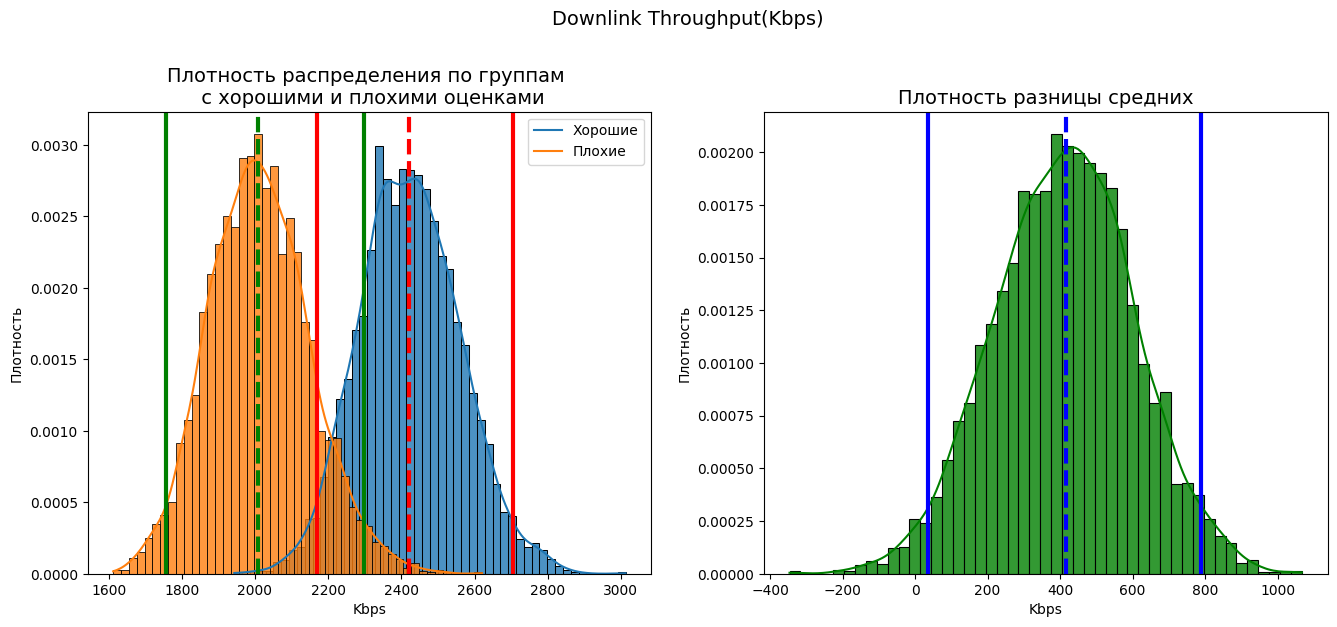

In [65]:
bootstrap(data_a=df[df['Q1'] >= 7]['Downlink Throughput(Kbps)'],
          data_b=df[df['Q1'] <= 6]['Downlink Throughput(Kbps)'],
          N=5000, size=300, title='Downlink Throughput(Kbps)')

Доверительные интрвалы пересекаются, но не накладываются. Разница среднего не проходит через ноль. Нулевую гипотезу отвергаем
$$
  H_1 : \mu_c \neq \mu_0
$$ 

## Выводы

Для повышения качества оказываемых услуг наибольшее внимание стоит уделить улучшению качества мобильного интернета и улучшения качества связи в зданиях
Необходимо повысить средняюю скорость "к абоненту", скорост загрузки потокового видео"

## 4.2 Анализ групп довольных/недовольных абонентов и причин указанных в ответах Q2

## Постановка задачи

Проведем оценку вариантов ответов абонентов, довольных и недовольных качеством оказываемых услуг. Это позволит понять в каких напредлениях необходимо улучшение и модернизация услуг(улучшение связи,увеличение скорости интернета)

## Разведочный анализ

Анализ переменной принадлежности к группе довольных/недовольных качеством услуг

In [66]:
# Обзор распределения
df['Group'].value_counts()

0    1945
1    1069
Name: Group, dtype: int64

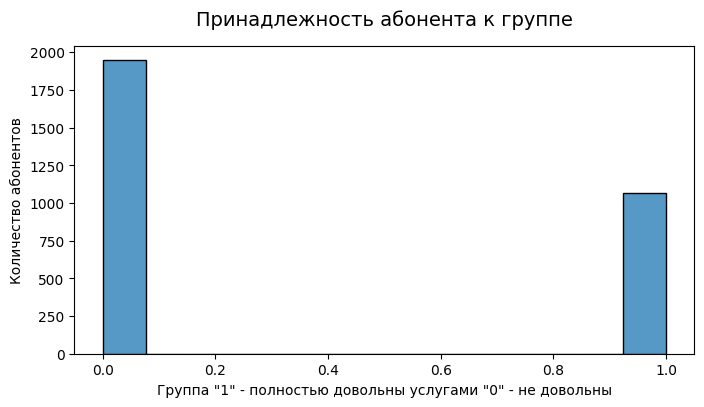

In [67]:
plt.figure(figsize=(8, 4))
sns.histplot(df, x='Group',)
title = 'Принадлежность абонента к группе'
xlab = 'Группа "1" - полностью довольны услугами "0" - не довольны'
ylab = 'Количество абонентов'
plt.title(title, fontsize=14, pad=15)
plt.ylabel(ylab)
plt.xlabel(xlab)
plt.show()

Зависимость переменной принадлежности к группе довольных/недовольных  качеством услуг абонентов от технических характеристик

#### Влияние ответов на вопрос Q2 на переменную принадлежности к группе довольных/недовольных качество услуг

In [68]:
TARGET_NAME = 'Group'
Q2_FEATURE_NAMES = []
Q2_FEATURE_NAMES.append('Q2_1')
Q2_FEATURE_NAMES.append('Q2_2')
Q2_FEATURE_NAMES.append('Q2_3')
Q2_FEATURE_NAMES.append('Q2_4')
Q2_FEATURE_NAMES.append('Q2_5')
Q2_FEATURE_NAMES.append('Q2_6')
Q2_FEATURE_NAMES.append('Q2_7')

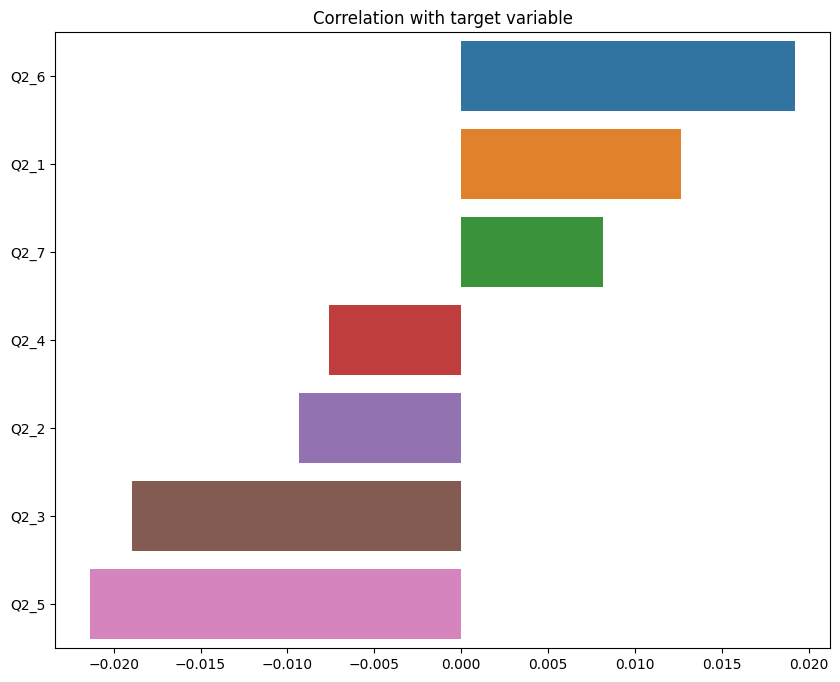

In [69]:
corr_with_target = df[Q2_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

На основании графика, можно отметить корреляцию "Слабую"(0,1 - 0,3 по модулю)
между тем, какие причины оказали влияние на оценку у абонентов:
    <li>Q2_6 "Затрудняюсь ответить"</li>
    <li>Q2_1 "Недозвоны, обрывы при звонке" </li>
    <li>Q2_5 "Медленная загрузка видео,</li>
    <li>Q2_3 "Плохое качество связи в зданиях, торговых центрах;</li>

## Статистический анализ

### Оценка признака (медленная загрузка видео Video Streaming xKB Start Delay(ms)) в разрезе переменной принадлежности к группе абонентов

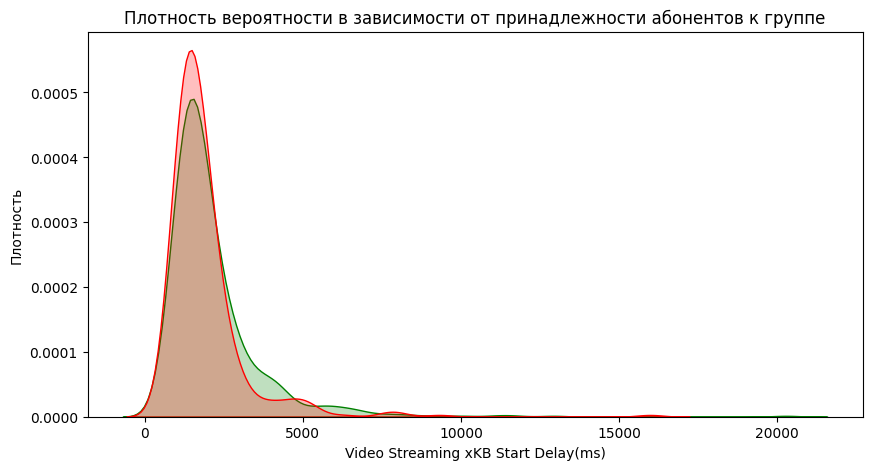

In [70]:
TARGET_NAME = 'Group'
q2_5_with_group = df[['Video Streaming xKB Start Delay(ms)', TARGET_NAME]].sample(1000)
q2_5_s= q2_5_with_group['Video Streaming xKB Start Delay(ms)']
q2_5_0 = q2_5_s[q2_5_with_group[TARGET_NAME] == 0]
q2_5_1 = q2_5_s[q2_5_with_group[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(q2_5_0, shade=True, label='No default', color='g')
sns.kdeplot(q2_5_1, shade=True, label='Default', color='r')

plt.xlabel('Video Streaming xKB Start Delay(ms)')
plt.ylabel('Плотность')
plt.title('Плотность вероятности в зависимости от принадлежности абонентов к группе')
plt.show()

Есть вероятность, что между признаком медленная загрузка видео Video Streaming xKB Start Delay(ms)  и переменной "Group" (1 - удовлeтворены услугами/ 0 - не удовлетворены) существует некоторая функциональная зависимость.

Гипотеза
<li>Нулевая гипотеза: средние значения в двух независимых выборках равны</li>
<li>Альтернативная гипотеза: средние значения в двух независимых выборках различаются</li>
<li>Критерий: критерий Стьюдента (t-тест)</li>
<li>Уровень значимости α: 0.05</li>
<li>Критическая область: двухсторонняя</li>

Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка

In [71]:
shapiro(q2_5_s)

ShapiroResult(statistic=0.6219315528869629, pvalue=3.637770813387225e-42)

Так как значение p-value сильно меньше 0.05, можно сделать вывод, что гипотеза о "нормальности" отвергается.

Т.к. в выбороке более 1000 наблюдений, критерий Шапиро-Уилка не даст верную оценку нормальности распределения. Поэтому строим QQ-plot и гистограмму для визуальной проверки выборок на нормальность распределения.Для достоверности проведем визуальную оценку распределения признака, а так же постороим QQ-график

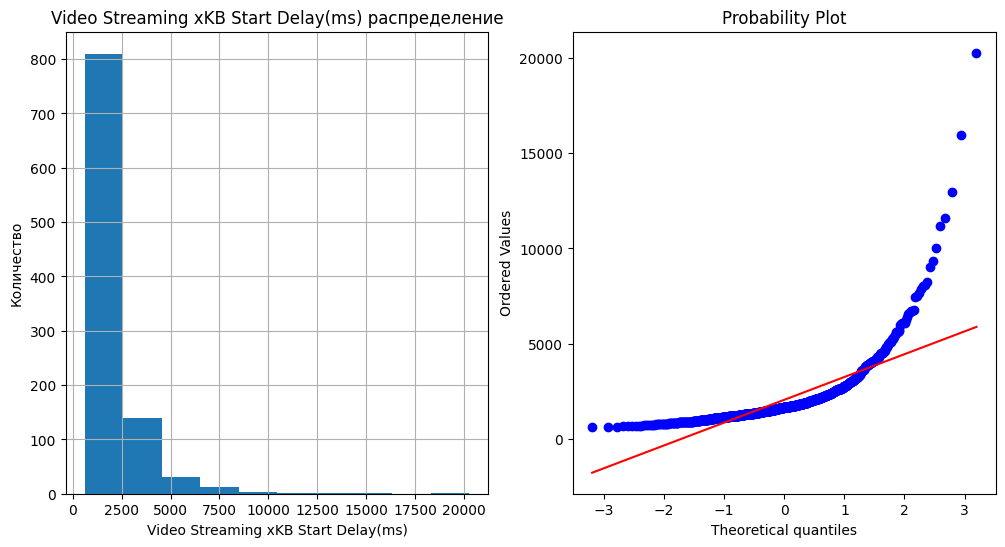

In [72]:
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(121)
ax1.set_xlabel('Video Streaming xKB Start Delay(ms)')
ax1.set_ylabel('Количество')
ax1.set_title('Video Streaming xKB Start Delay(ms) распределение')
q2_5_s.hist()

plt.subplot(122)
probplot(q2_5_s, dist='norm', plot=plt)

plt.show()

Оценим эквивалентность мат. ожиданий в исследуемых группах с помощью критерия Манна-Уитни.

In [73]:
mannwhitneyu(q2_5_0, q2_5_1)

MannwhitneyuResult(statistic=126195.0, pvalue=0.0033908133289285627)

Согласно значению p-value, гипотеза о равности мат. ожиданий не подтверждается.

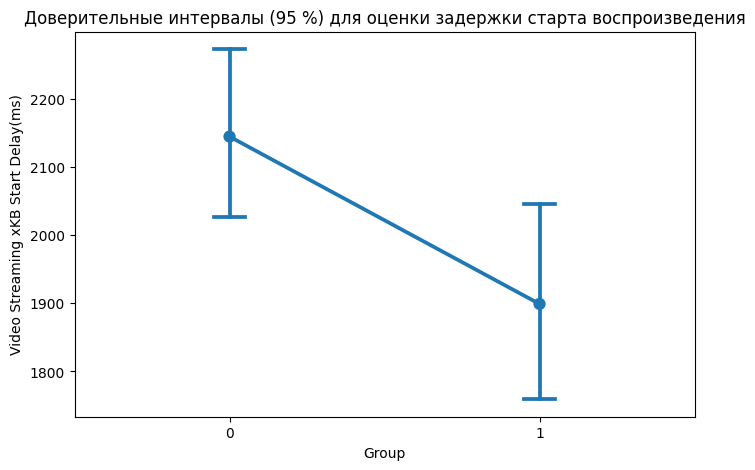

In [74]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Video Streaming xKB Start Delay(ms)', data=q2_5_with_group, capsize=.1)

plt.title('Доверительные интервалы (95 %) для оценки задержки старта воспроизведения')
plt.show()

График подтверждает, что интервалы не пересекаются, это подтверждает результаты полученные с помощью критерия Манна-Уитни.

Полученные результаты означают, что выборки имеют существенные различия.

### Оценка пинга  при просмотре web-страниц (Web Average TCP RTT(ms))—  в разрезе переменной принадлежности к группе абонентов

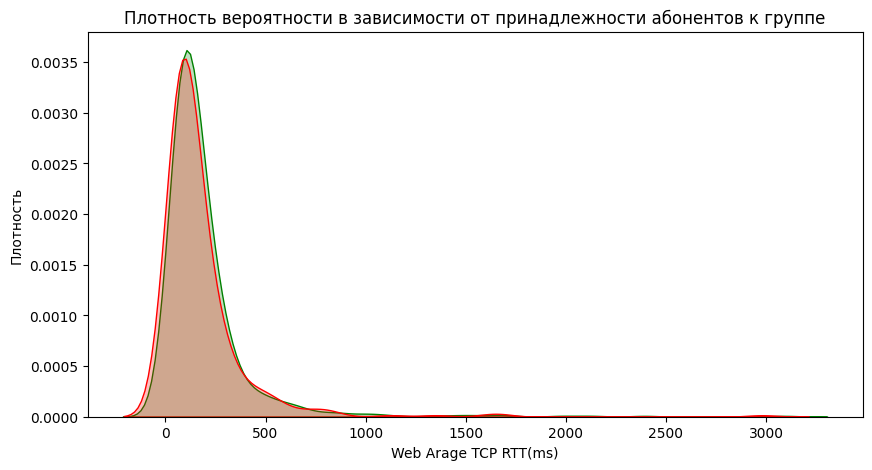

In [75]:
TARGET_NAME = 'Group'
q2_1_with_group = df[['Web Average TCP RTT(ms)', TARGET_NAME]].sample(1000)
q2_1_s= q2_1_with_group['Web Average TCP RTT(ms)']
q2_1_0 = q2_1_s[q2_1_with_group[TARGET_NAME] == 0]
q2_1_1 = q2_1_s[q2_1_with_group[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(q2_1_0, shade=True, label='No default', color='g')
sns.kdeplot(q2_1_1, shade=True, label='Default', color='r')

plt.xlabel('Web Arage TCP RTT(ms)')
plt.ylabel('Плотность')
plt.title('Плотность вероятности в зависимости от принадлежности абонентов к группе')
plt.show()

Есть вероятность, что между признаком "Q2_1"(недозвоны, обрывы при звонках) и переменной "Group" (1 - удовлeтворены услугами/ 0 - не удовлетворены) существует некоторая функциональная зависимость.

Гипотеза
<li>Нулевая гипотеза: средние значения в двух независимых выборках равны</li>
<li>Альтернативная гипотеза: средние значения в двух независимых выборках различаются</li>
<li>Критерий: критерий Стьюдента (t-тест)</li>
<li>Уровень значимости α: 0.05</li>
<li>Критическая область: двухсторонняя</li>

Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка

Т.к. в выбороке более 1000 наблюдений, критерий Шапиро-Уилка не даст верную оценку нормальности распределения. Поэтому строим QQ-plot и гистограмму для визуальной проверки выборок на нормальность распределения.Для достоверности проведем визуальную оценку распределения признака, а так же постороим QQ-график

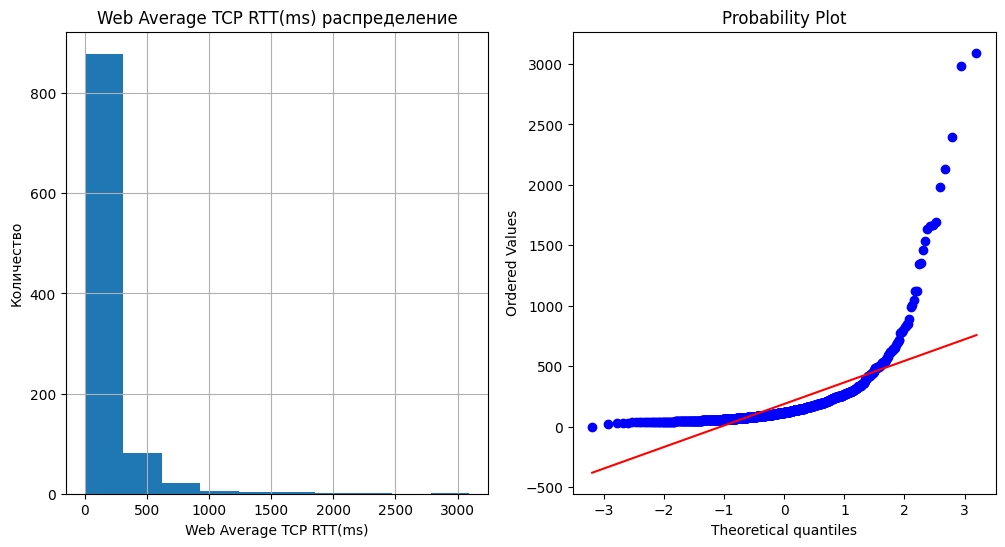

In [76]:
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(121)
ax1.set_xlabel('Web Average TCP RTT(ms)')
ax1.set_ylabel('Количество')
ax1.set_title('Web Average TCP RTT(ms) распределение')
q2_1_s.hist()

plt.subplot(122)
probplot(q2_1_s, dist='norm', plot=plt)

plt.show()

Оцениваю эквивалентность мат. ожиданий в исследуемых группах с помощью критерия Манна-Уитни.
Этот критерий выбран так как он используется для сравнения выраженности показателей в двух несвязных выборках.

In [77]:
mannwhitneyu(q2_1_0, q2_1_1)

MannwhitneyuResult(statistic=126096.0, pvalue=0.0017254400360963023)

Согласно значению p-value, гипотеза о равности мат. ожиданий не подтверждается.

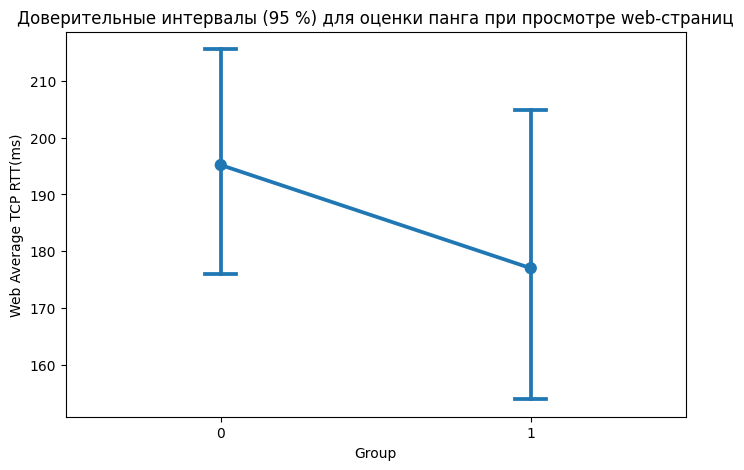

In [78]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Web Average TCP RTT(ms)', data=q2_1_with_group, capsize=.1)

plt.title('Доверительные интервалы (95 %) для оценки панга при просмотре web-страниц')
plt.show()

Доверительные интервалы также показывают, что выборки имеют существенные различия.

##  4.3 Сравнение средних значений технических характеристик интернета в зависимости от ответов на вопрос Q2

## Постановка задачи
Проведем анализ ответов абонентов, не поставившим высокую оценку на вопрос Q1 и указавшим в качестве причин "Медленный мобильный интернет"(Q2_4) и "Медленая загрузка видео"(Q2_5).
Данный анализ позволит понять объективность ответов абонентов и покажет целесообразность усовершнствования или модернизации технических систем. В первую очередь рассмотрим среднее значение объема трафика передачт данных в двух группах. 

## Разведочный анализ

In [79]:
df_1 = df[(df['Q2_4'] > 0) & (df['Q1'] < 9)]
df_2 = df[(df['Q2_5'] > 0) & (df['Q1'] < 9)]
df_bad_mark = pd.concat([df_1, df_2], ignore_index=True)
df_bad_mark

,user_id,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms),count_answer,Q2_1,Q2_2,Q2_3,Q2_4,Q2_5,Q2_6,Q2_7,Group
0,2,5,[4],861.96324,3023.54,411.18,1.27,667.47,2080,255.36,425,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,3,1,[4],261.11860,790.96,34.20,1.79,1079.60,6367,535.85,485,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,5,2,"[2, 3, 4]",351.99208,731.61,223.54,1.15,4550.38,1767,2336.56,68,7,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0
3,7,2,"[4, 5]",448.88413,438.27,81.32,1.98,1699.64,4223,856.05,220,4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0
4,9,1,"[1, 3, 4]",783.64464,1786.99,271.77,0.84,6802.42,1200,1837.02,132,7,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,2980,8,[4],466.72780,1620.30,29.91,0.74,5219.67,1704,375.36,2533,1,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0
542,2989,1,[1],240.08770,647.49,32.22,2.47,1777.88,1592,2854.93,134,1,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0
543,3037,1,"[1, 2, 3, 4]",101.14382,277.87,532.47,1.67,3031.35,1202,1569.08,256,10,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0
544,3046,8,[1],850.24828,564.14,36.71,0.51,7388.43,1383,1305.23,336,1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0


#### Рассмотрим среднее значение объема трафика передачи данных в двух группах

In [80]:
df_bad_vstream = df_bad_mark [['Video Streaming xKB Start Delay(ms)']].copy()
df_bad_vstream.head(2)

,Video Streaming xKB Start Delay(ms)
0,2080
1,6367


In [81]:
df_good_mark = df[df['Q1'] < 9]
df_good_mark = df.drop(['Q2_4', 'Q2_5','Q2'], axis='columns') 
df_good_vstream = df_good_mark[['Video Streaming xKB Start Delay(ms)']].copy()
df_good_vstream = df_good_vstream.sample(546)
df_good_vstream.head(2)

,Video Streaming xKB Start Delay(ms)
2545,1195
1895,2985


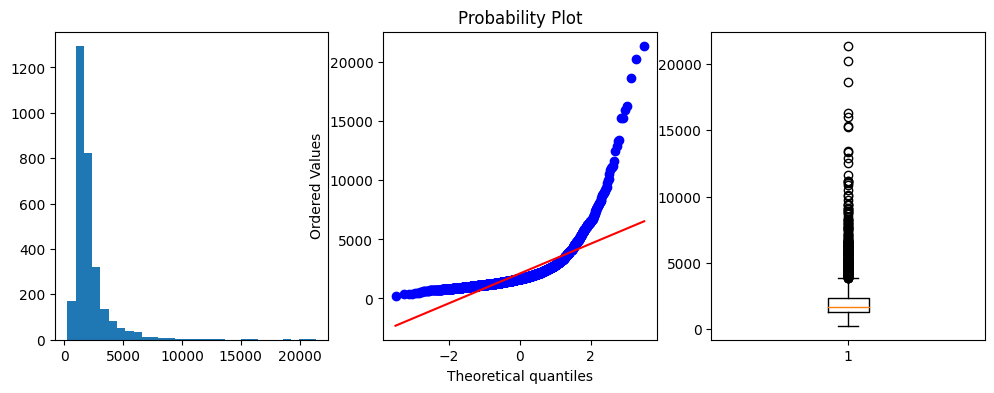

In [82]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(df['Video Streaming xKB Start Delay(ms)'], bins=30)

plt.subplot(1, 3, 2)
st.probplot(df['Video Streaming xKB Start Delay(ms)'], plot=plt)

plt.subplot(1, 3, 3)
plt.boxplot(df['Video Streaming xKB Start Delay(ms)'])

plt.show()

## Статистичекий анализ

Гипотеза
<li>Нулевая гипотеза: средние значения задержки старта воспроизведения в двух независимых выборках равны</li>
<li>Альтернативная гипотеза: средние значения в двух независимых выборках различаются</li>
<li>Критерий: критерий Стьюдента (t-тест)</li>
<li>Уровень значимости α: 0.05</li>
<li>Критическая область: двухсторонняя</li>

Проверка распределения признака на "нормальность" с помощью критерия Манна-Уитни

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


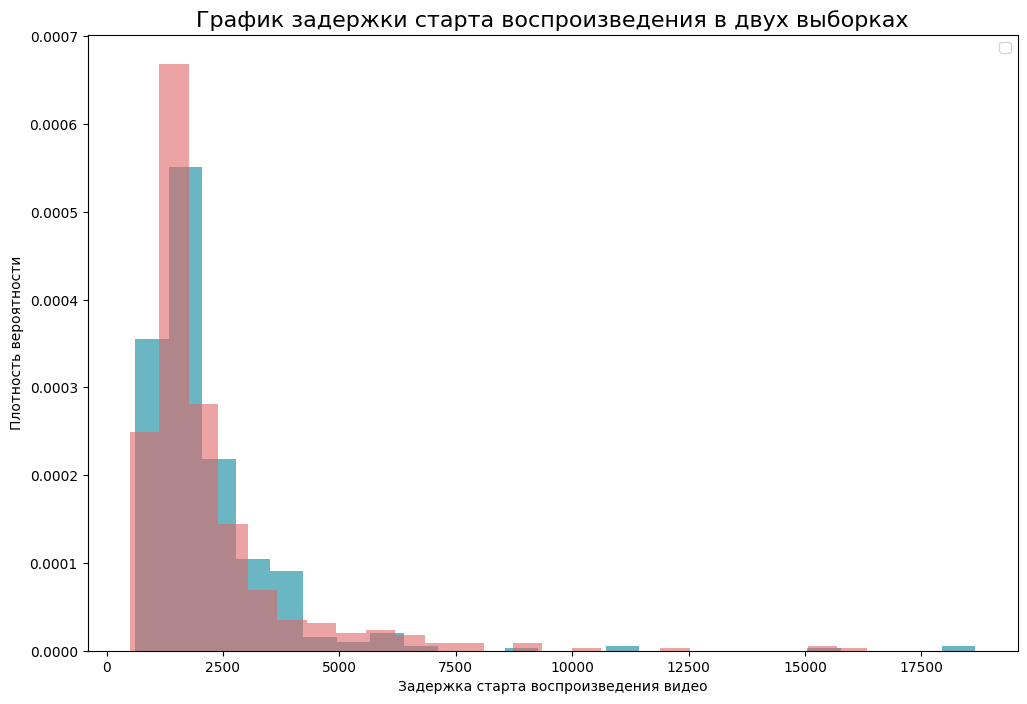

In [83]:
df_bad_vstream_mean = df_bad_vstream.mean()
df_good_vstream_mean = df_good_vstream.mean()

plt.figure(figsize=(12,8))
plt.hist(df_bad_vstream, bins=25, density=True, alpha=0.6, color='#07889b')
plt.hist(df_good_vstream , bins=25, density=True, alpha=0.6, color='#e06666')



plt.xlabel('Задержка старта воспроизведения видео')
plt.ylabel('Плотность вероятности')
plt.title('График задержки старта воспроизведения в двух выборках', fontsize=16)
plt.legend()

Из графика видно, что средние значения схожи, но проведем t-теста.

Оцениваю эквивалентность средних значений в исследуемых группах с помощью критерия Манна-Уитни.

In [84]:
mannwhitneyu(df_bad_vstream, df_good_vstream)

MannwhitneyuResult(statistic=array([156088.]), pvalue=array([0.17733594]))

In [85]:
st.ttest_ind(df_bad_vstream, df_good_vstream, equal_var=False, nan_policy = 'omit')

Ttest_indResult(statistic=array([-0.26890094]), pvalue=array([0.788057]))

## Выводы

Поскольку p-значение (0.17) нашего теста больше, чем альфа = 0,05, мы можем принять нулевую гипотезу теста. Средние значения задержки старта воспроизведения видео в обеих группах схожи

## Постановка задачи
Проведем анализ ответов абонентов, не поставившим высокую оценку на вопрос Q1 и указавшим в качестве причин "Медленный мобильный интернет"(Q2_4) и "Медленая загрузка видео"(Q2_5).
Данный анализ позволит понять объективность ответов абонентов и покажет целесообразность усовершнствования или модернизации технических систем. Рассмотрим значение средней скорости к абоненту в обеих группах.

## Разведочный анализ

In [86]:
df_bad_dlink = df_bad_mark [['Downlink Throughput(Kbps)']].copy()
df_bad_dlink.head(2)

,Downlink Throughput(Kbps)
0,3023.54
1,790.96


In [87]:
df_good_dlink= df_good_mark[['Downlink Throughput(Kbps)']].copy()
df_good_dlink = df_good_dlink.sample(546)
df_good_dlink.head(2)

,Downlink Throughput(Kbps)
1208,148.78
2099,426.76


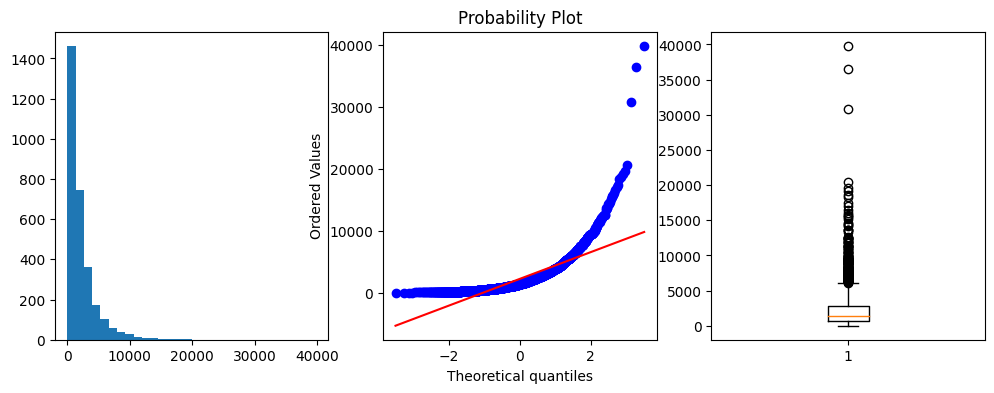

In [88]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(df['Downlink Throughput(Kbps)'], bins=30)

plt.subplot(1, 3, 2)
st.probplot(df['Downlink Throughput(Kbps)'], plot=plt)

plt.subplot(1, 3, 3)
plt.boxplot(df['Downlink Throughput(Kbps)'])

plt.show()

## Статистический анализ
Гипотеза
<li>Нулевая гипотеза: средние значения скорость в абоненту в двух независимых выборках равны</li>
<li>Альтернативная гипотеза: средние значения в двух независимых выборках различаются</li>
<li>Критерий: критерий Стьюдента (t-тест)</li>
<li>Уровень значимости α: 0.05</li>
<li>Критическая область: двухсторонняя</li>

Проверка распределения признака на "нормальность" с помощью критерия Манна-Уитни

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


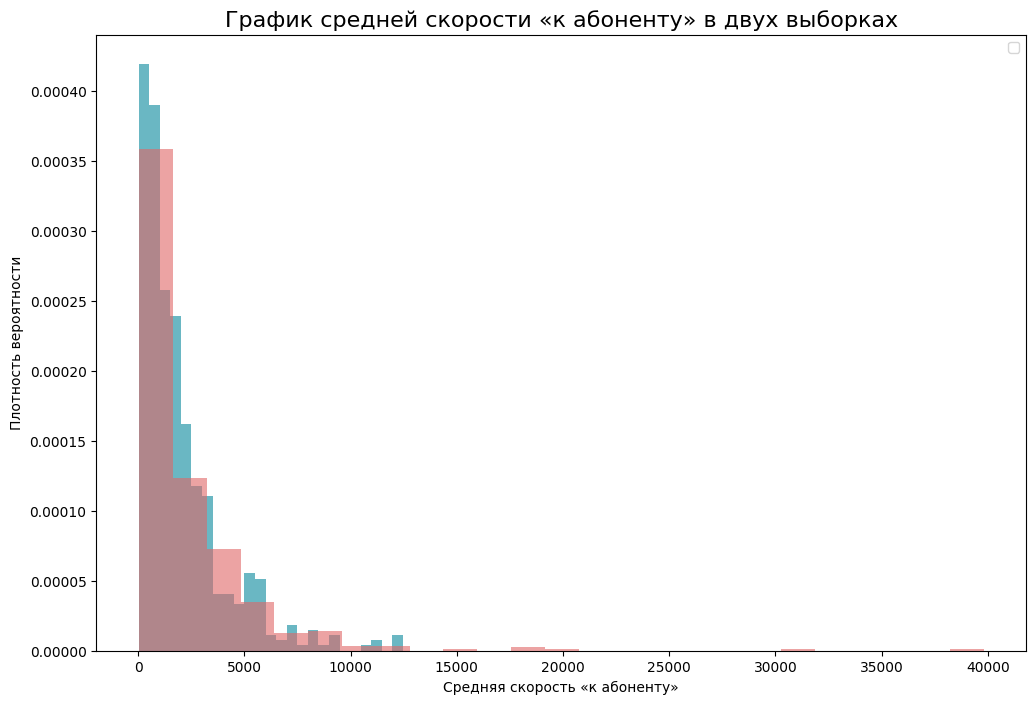

In [89]:
df_bad_dlink_mean = df_bad_dlink.mean()
df_good_dlink_mean = df_good_dlink.mean()

plt.figure(figsize=(12,8))
plt.hist(df_bad_dlink, bins=25, density=True, alpha=0.6, color='#07889b')
plt.hist(df_good_dlink , bins=25, density=True, alpha=0.6, color='#e06666')



plt.xlabel('Средняя скорость «к абоненту»')
plt.ylabel('Плотность вероятности')
plt.title('График средней скорости «к абоненту» в двух выборках', fontsize=16)
plt.legend()

Из графика видно, что средние значения схожи, но проведем t-теста.
Оцениваю эквивалентность средних значений в исследуемых группах с помощью критерия Манна-Уитни.

In [90]:
mannwhitneyu(df_bad_dlink, df_good_dlink)

MannwhitneyuResult(statistic=array([141347.5]), pvalue=array([0.13898166]))

In [91]:
st.ttest_ind(df_bad_dlink, df_good_dlink, equal_var=False, nan_policy = 'omit')

Ttest_indResult(statistic=array([-2.38813786]), pvalue=array([0.01713368]))

## Выводы
Поскольку p-значение (0.059) нашего теста больше, чем альфа = 0,05, мы можем принять нулевую гипотезу теста. Средние значения задержки старта воспроизведения видео в обеих группах схожи.

Средняя скорость к абоненту, а так же время задержки старта воспроизведения видео, одни из параметров которые влияют на принятие решения абонентов о удовлетворенности услугами интернета. Для двух групп абонентов, поставивших не самую высокую оценку на вопрос Q1 и непоставивших таковую средние значения перечисленных выше технических параметров схожи, а значит причины неудовлетворенности услугами интернет зависят от другого параметра или мы имеем недостаточное количесво значений в наборе данных.